# 사용할 패키지

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from tqdm import tqdm

import tensorflow as tf
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Conv3D, ConvLSTM2D, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from keras import backend as K

# TPU 장치 설정

In [2]:
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
tf.config.experimental_connect_to_cluster(resolver)
# This is the TPU initialization code that has to be at the beginning.
tf.tpu.experimental.initialize_tpu_system(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))

INFO:tensorflow:Initializing the TPU system: grpc://10.3.40.130:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.3.40.130:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


All devices:  [LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU')]


In [ ]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  
    # TPU detection. No parameters necessary if TPU_NAME environment variable is set. On Kaggle this is always the case.
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() 
    # default distribution strategy in Tensorflow. Works on CPU and single GPU.
print("REPLICAS: ", strategy.num_replicas_in_sync)

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
path = '/content/drive/MyDrive/'

# 데이터 가져오기

In [6]:
train_csv = pd.read_csv(path+'train.csv')

In [ ]:
train_csv.head(30)

전체 데이터중 최근 30년 데이터만 학습에 사용하였습니다.

In [8]:
train_path = sorted(glob('/content/drive/MyDrive/train/*.npy'))
train_path = train_path[-30*12:]

In [9]:
train = []
for p in tqdm(train_path):
    train.append(np.load(p))
train = np.array(train)

100%|██████████| 360/360 [01:28<00:00,  4.09it/s]


In [10]:
train.shape

(360, 448, 304, 5)

# 데이터 시각화

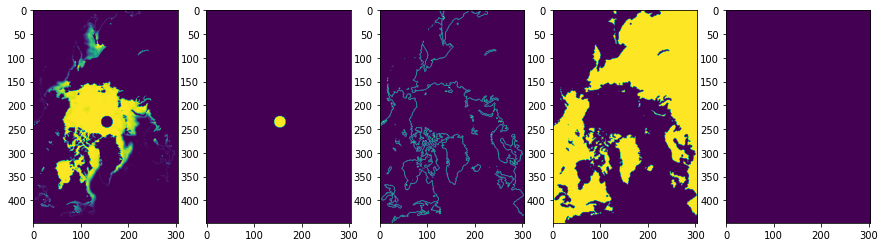

In [ ]:
plt.figure(figsize=(15,10))
plt.subplot(151)
plt.imshow(train[0,:,:,0])
plt.subplot(152)
plt.imshow(train[0,:,:,1])
plt.subplot(153)
plt.imshow(train[0,:,:,2])
plt.subplot(154)
plt.imshow(train[0,:,:,3])
plt.subplot(155)
plt.imshow(train[0,:,:,4])

In [ ]:
missings = pd.DataFrame()

for k in range(360) : 
  missings = pd.concat([missings,pd.DataFrame(train[k,:,:,4].reshape(-1,1))],ignore_index=True)

print(missings.min().min())
print(missings.max().max())

0
0


In [11]:
train[0,:,:,0] + train[0,:,:,1]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [12]:
for k in range(360) :

  new_array = train[k,:,:,0] + train[k,:,:,1]*250
  train[k,:,:,0] = new_array

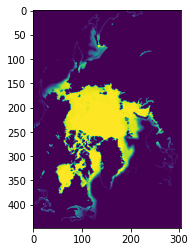

In [13]:
plt.imshow(train[0,:,:,0])

In [ ]:
train.shape

(360, 448, 304, 5)

# 월별 데이터로 분리

In [14]:
train_month = []
for i in range(12):
    train_month.append(train[i::12, :])
train_month = np.array(train_month)

In [15]:
train_month.shape

(12, 30, 448, 304, 5)

## 10년 단위로 데이터 전처리

In [18]:
window_size = 10

In [19]:
x_train = []
y_train = []

for i in range(train_month.shape[1]-window_size):
    x_train.append(train_month[:, i:i+window_size, : , :, :])
    y_train.append(train_month[:, i+window_size:i+window_size+1, :, :, :])
    
x_train = np.array(x_train)
y_train = np.array(y_train)

In [20]:
x_train.shape, y_train.shape

((20, 12, 10, 448, 304, 5), (20, 12, 1, 448, 304, 5))

# 데이터 자르기


In [21]:
#stride = 32
#feature_size = 128

x_train_ = []
y_train_ = []

for y in range(18):
  for m in range(12):
      x_ = x_train[y, m, :, :, :,:1]  
      y_ = y_train[y, m, :, :, :,:1] 
      x_train_.append(x_)
      y_train_.append(y_)

x_train_ = np.array(x_train_)
y_train_ = np.array(y_train_)

x_val_ = []
y_val_ = []

for y in range(18,19):
  for m in range(12):
    x_ = x_train[y, m, :, :, :,:1]
    y_ = y_train[y, m, :, :, :,:1]
    x_val_.append(x_)
    y_val_.append(y_)

x_val_ = np.array(x_val_)
y_val_ = np.array(y_val_)

x_test_ = []
y_test_ = []

for y in range(19,20):
 for m in range(12):
    x_ = x_train[y, m, :, :, :,:1]
    y_ = y_train[y, m, :, :, :,:1]
    x_test_.append(x_)
    y_test_.append(y_)

x_test_ = np.array(x_test_)
y_test_ = np.array(y_test_)

In [22]:
x_train_.shape, y_train_.shape, x_val_.shape, y_val_.shape, x_test_.shape, y_test_.shape

((216, 10, 448, 304, 1),
 (216, 1, 448, 304, 1),
 (12, 10, 448, 304, 1),
 (12, 1, 448, 304, 1),
 (12, 10, 448, 304, 1),
 (12, 1, 448, 304, 1))

In [23]:
def train_map_func(x, y):
    x = tf.cast(x, tf.float32)
    y = tf.cast(y, tf.float32)
    return x, y

In [45]:
BATCH_SIZE = 10

In [46]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train_, y_train_))
train_dataset = train_dataset.map(train_map_func, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((x_val_, y_val_))
val_dataset = val_dataset.map(train_map_func, num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE)
val_dataset = val_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((x_test_, y_test_))
test_dataset = test_dataset.map(train_map_func, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [47]:
next(iter(train_dataset))[0].shape, next(iter(train_dataset))[1].shape

(TensorShape([10, 10, 448, 304, 1]), TensorShape([10, 1, 448, 304, 1]))

# 모델



In [27]:
from tensorflow import keras

In [28]:
import keras
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate

from keras.layers import Input, Conv2D, Flatten, Dense, Conv2DTranspose,Reshape
from keras.layers import Activation, LeakyReLU, Dropout, BatchNormalization, MaxPooling3D, UpSampling2D, UpSampling3D, Conv3DTranspose, concatenate, LSTM
from keras.models import Model
from keras import backend as K 
from keras.optimizers import Adam

In [70]:
with strategy.scope():
    inputs=Input((None, x_train_.shape[2], x_train_.shape[3], 1))

    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
#    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling3D(2)(conv1)

    conv2 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
#    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling3D(2)(conv2)

    conv3 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
#    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool3 = MaxPooling3D(2)(conv3)

#    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
#    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)


    convLSTM = ConvLSTM2D(filters=128, kernel_size=3, padding='same', return_sequences=True)(pool3)
    convLSTM = BatchNormalization()(convLSTM)

    convLSTM = ConvLSTM2D(filters=128, kernel_size=3, padding='same', return_sequences=True)(convLSTM)
    convLSTM = BatchNormalization()(convLSTM)

#    convLSTM = ConvLSTM2D(filters=64, kernel_size=3, padding='same', return_sequences=True)(convLSTM)
#    convLSTM = BatchNormalization()(convLSTM)


    up7 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling3D(2)(convLSTM))
#    merge7 = concatenate([conv3,up7],axis = 1)
    conv7 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(up7)
#    conv7 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling3D(2)(conv7))
#    merge7 = concatenate([conv1,up8], axis = 1)
    conv8 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(up8)
#    conv7 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up9 = Conv2D(1, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling3D(2)(conv8))
#    merge8 = concatenate([inputs,up9], axis = 1)
    outputs = Conv2D(1, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(up9)
#    conv8 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

#    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

#    outputs = Conv2D(filters=1, kernel_size=3, activation='relu', padding='same', data_format='channels_last')(conv8)

    model = Model(inputs, outputs)
    model.compile(loss='mse', optimizer=Adam())
    
model.summary()

Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, None, 448, 304, 1 0         
_________________________________________________________________
conv2d_98 (Conv2D)           (None, None, 448, 304, 32 320       
_________________________________________________________________
max_pooling3d_37 (MaxPooling (None, None, 224, 152, 32 0         
_________________________________________________________________
conv2d_99 (Conv2D)           (None, None, 224, 152, 64 18496     
_________________________________________________________________
max_pooling3d_38 (MaxPooling (None, None, 112, 76, 64) 0         
_________________________________________________________________
conv2d_100 (Conv2D)          (None, None, 112, 76, 128 73856     
_________________________________________________________________
max_pooling3d_39 (MaxPooling (None, None, 56, 38, 128) 0  

In [58]:
with strategy.scope():
    inputs=Input((None, x_train_.shape[2], x_train_.shape[3], 1))

    x = Conv2D(filters=32,kernel_size=(3,3),padding='same')(inputs)
    x = BatchNormalization()(x)
#    x = Activation('relu')(x)
    x = MaxPooling3D(2)(x)

    x = Conv2D(filters=64,kernel_size=(3,3),padding='same')(x)
    x = BatchNormalization()(x)
#    x = Activation('relu')(x)
    x = MaxPooling3D(2)(x)

    convLSTM = ConvLSTM2D(filters=64, kernel_size=3, padding='same', return_sequences=True)(x)
    convLSTM = BatchNormalization()(convLSTM)

    convLSTM = ConvLSTM2D(filters=64, kernel_size=3, padding='same', return_sequences=True)(convLSTM)
    convLSTM = BatchNormalization()(convLSTM)

    convLSTM = ConvLSTM2D(filters=64, kernel_size=3, padding='same', return_sequences=True)(convLSTM)
    convLSTM = BatchNormalization()(convLSTM)

    x = UpSampling3D(2)(convLSTM)
    x = Conv3DTranspose(64,3,padding='same')(x)

    x = UpSampling3D(2)(x)
    x = Conv3DTranspose(32,3,padding='same')(x)

    outputs = Conv3D(filters=1, kernel_size=3, activation='relu', padding='same', data_format='channels_last')(x)

    model = Model(inputs, outputs)
    model.compile(loss='mse', optimizer=Adam())
    
model.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, None, 448, 304, 1 0         
_________________________________________________________________
conv2d_65 (Conv2D)           (None, None, 448, 304, 32 320       
_________________________________________________________________
batch_normalization_12 (Batc (None, None, 448, 304, 32 128       
_________________________________________________________________
max_pooling3d_23 (MaxPooling (None, None, 224, 152, 32 0         
_________________________________________________________________
conv2d_66 (Conv2D)           (None, None, 224, 152, 64 18496     
_________________________________________________________________
batch_normalization_13 (Batc (None, None, 224, 152, 64 256       
_________________________________________________________________
max_pooling3d_24 (MaxPooling (None, None, 112, 76, 64) 0   

# 학습

20epochs까지만 학습하였습니다.

In [ ]:
x_train_.shape

(216, 10, 448, 304, 1)

In [59]:
if not (os.path.isdir('models')):
    os.makedirs('models')

callbacks_list = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath = './models/convlstm_model.h5',
        monitor='val_loss',
        save_best_only=True
    )
]

hist = model.fit(train_dataset, epochs=50, validation_data=val_dataset, callbacks=callbacks_list)

Epoch 1/50
22/22 [==============================] - 109s 2s/step - loss: 3147.9799 - val_loss: 4414.0684
Epoch 2/50
22/22 [==============================] - 21s 975ms/step - loss: 1014.9197 - val_loss: 3741.9136
Epoch 3/50
22/22 [==============================] - 21s 974ms/step - loss: 672.4897 - val_loss: 3585.2498
Epoch 4/50
22/22 [==============================] - 21s 966ms/step - loss: 717.4637 - val_loss: 3007.6265
Epoch 5/50
22/22 [==============================] - 21s 973ms/step - loss: 590.1115 - val_loss: 2867.3171
Epoch 6/50
22/22 [==============================] - 22s 993ms/step - loss: 605.5732 - val_loss: 2342.0498
Epoch 7/50
22/22 [==============================] - 21s 974ms/step - loss: 544.8454 - val_loss: 2117.8367
Epoch 8/50
22/22 [==============================] - 21s 970ms/step - loss: 544.8660 - val_loss: 1757.7186
Epoch 9/50
22/22 [==============================] - 21s 975ms/step - loss: 508.2030 - val_loss: 1537.6003
Epoch 10/50
22/22 [===========================

# 학습 결과

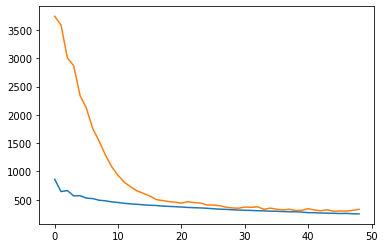

In [60]:
plt.plot(hist.history['loss'][1:])
plt.plot(hist.history['val_loss'][1:])
plt.show()

# 모델 불러오기

In [61]:
model = load_model('/content/models/convlstm_model.h5')

# 검증셋 추론

In [62]:
pred = model.predict(next(iter(val_dataset))[0])
pred = np.where(pred>250, 250, pred)

In [53]:
pred.shape

(10, 16, 448, 304, 1)

## 검증셋 추론 결과

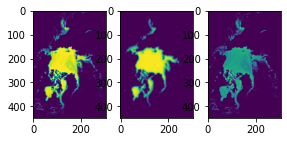

56.721153


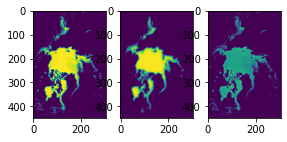

60.097523


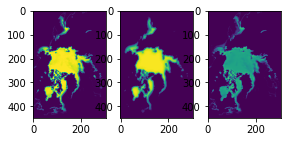

60.874435


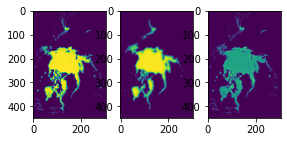

60.174126


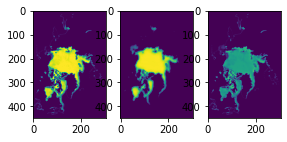

56.132336


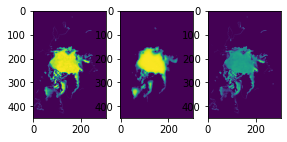

47.18515


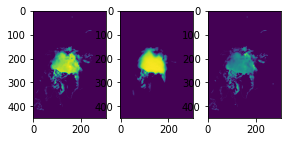

34.31262


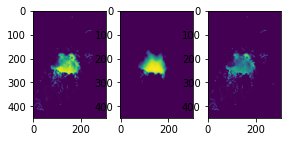

28.127434


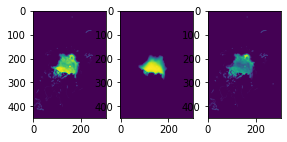

28.404547


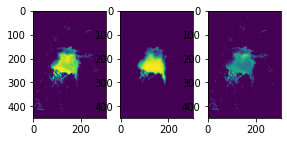

35.609768


In [63]:
for i in range(10):
  plt.subplot(141)
  plt.imshow(next(iter(val_dataset))[1][i,0,:,:,0])
  plt.subplot(142)
  plt.imshow(pred[i,0,:,:,0])
  plt.subplot(143)
  plt.imshow(np.abs(next(iter(val_dataset))[1][i,0,:,:,0] - pred[i,0,:,:,0]))
  plt.show()
  print(np.sqrt(np.mean(np.square(next(iter(val_dataset))[1][i,0,:,:,0] - pred[i,0,:,:,0]))))
    

In [64]:
pred = model.predict(next(iter(test_dataset))[0])
pred = np.where(pred>250, 250, pred)

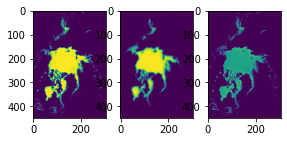

59.132683


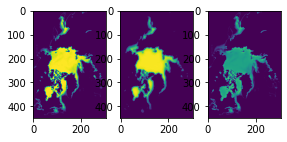

61.145466


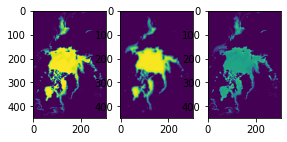

62.273834


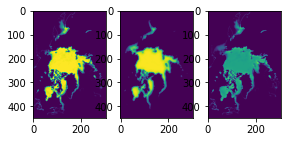

61.256157


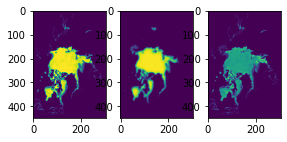

56.086796


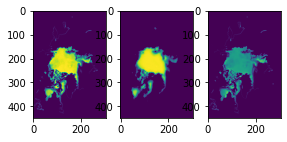

48.50819


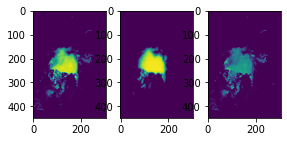

34.328674


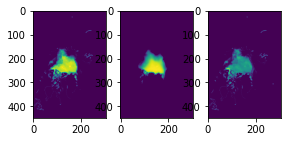

30.125912


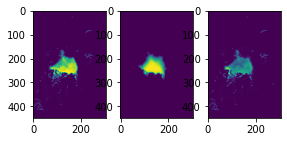

28.203356


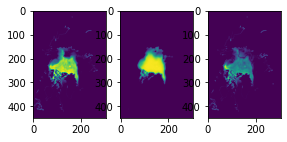

31.511398


In [65]:
for i in range(10):
  plt.subplot(141)
  plt.imshow(next(iter(test_dataset))[1][i,0,:,:,0])
  plt.subplot(142)
  plt.imshow(pred[i,0,:,:,0])
  plt.subplot(143)
  plt.imshow(np.abs(next(iter(test_dataset))[1][i,0,:,:,0] - pred[i,0,:,:,0]))
  plt.show()
  print(np.sqrt(np.mean(np.square(next(iter(test_dataset))[1][i,0,:,:,0] - pred[i,0,:,:,0]))))
    


# 2019년 추론 데이터 전처리

2014 ~ 2018년까지 5년간 월별 데이터를 학습과 같은 형태로 전처리

# 추론

각 월별 추론하여 저장

# TTS

추론 결과 중복된 영역의 경우 평균을 이용해 앙상블

stride값이 작을 수록 앙상블에의해 결과가 좋아지나 일정값 이상으로 작아지면 큰 효과가 없고 추론시간이 기하급수적으로 늘어납니다.

평균 계산용 마스크

# 추론 결과

# 제출

In [ ]:
submission = pd.read_csv(path+'sample_submission.csv')
submission

submission의 값을 변경할 경우 시간이 오래걸려 추론 결과를 reshape하여 붙였습니다.

In [ ]:
sub_2019 = submission.loc[:11, ['month']].copy()
sub_2020 = submission.loc[12:].copy()

sub_2019 = pd.concat([sub_2019, (pd.DataFrame(results.reshape([12,-1])))], axis=1)
sub_2019.columns = submission.columns
submission = pd.concat([sub_2019, sub_2020])

In [ ]:
submission

결과 저장

In [ ]:
submission.to_csv('submission.csv', index=False)